In [1]:
import sklearn
from sklearn.linear_model import Ridge
import time
from scipy.io import loadmat
import scipy.io
import functionList
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

In [2]:
raw = loadmat(r"C:\Users\parkf\Desktop\summer2021\eegData\for_Barry\282L.mat") #change this to try different one off files
X = raw['data']   #[0][0]['data'] #file format is different from ###L/R.mat vs the sample data
mask = raw['mask']
l = X.shape[0]

In [3]:
#holdStack = X
#for i in range(9):
#    X = np.hstack((X,holdStack))

In [4]:
memVec = [4, 8, 16, 20]
ridgeVec = [.1, .5, 1, 10]
ridgeVecNormal = np.dot(ridgeVec,l)
cvNum = 3

s = (len(memVec),len(ridgeVec),cvNum)
error = np.zeros(s)
runTimes = np.zeros(s)
for memNumber in memVec:
    featureMat = functionList.buildFeatureMat(X,memNumber)
    xClean = functionList.removeTrash(X,mask,memNumber)
    featureMat = functionList.removeTrash(featureMat,mask,memNumber)
    #saveThis = {"dataToCheck": featureMat} #to save as a matlab file to check the cleaning function
    #scipy.io.savemat("checkClean.mat",saveThis)
    for regularizer in ridgeVecNormal: 
        RR = Ridge(alpha=regularizer)
        crossVal = sklearn.model_selection.KFold(n_splits=cvNum)
        cvRun = 0
        for train, test in crossVal.split(featureMat):
            start = time.time()
            RR.fit(featureMat[train,:],xClean[train])
            end = time.time()
            pred = RR.predict(featureMat[test])
            error[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = error[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] + functionList.findMSE(pred, xClean[test])
            runTimes[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = end - start
            cvRun = cvRun + 1


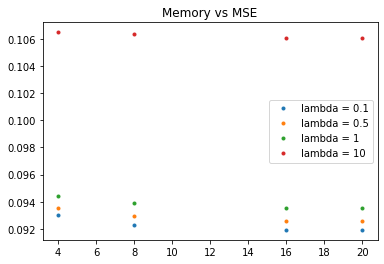

In [5]:
plt.title("Memory vs MSE") #### can update the code below with this type of loop
eAvg = np.sum(error,axis=2)/cvNum
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], eAvg[:,i], ".", label = f"lambda = {ridgeVec[i]}")
plt.legend()
plt.show()

In [6]:
#print(runTimes)
#print("errors below")
#print(error)
#print(np.sum(error,axis=2)/cvNum)

In [7]:
errorGpu = np.zeros(s)
runTimesGpu = np.zeros(s)
for memNumber in memVec:
    featureMat = functionList.buildFeatureMat(X,memNumber)
    xClean = functionList.removeTrash(X,mask,memNumber)
    featureMat = functionList.removeTrash(featureMat,mask,memNumber)
    for regularizer in ridgeVecNormal: 
        crossVal = sklearn.model_selection.KFold(n_splits=cvNum)
        cvRun = 0
        for train, test in crossVal.split(featureMat):
            start = time.time()
            w = functionList.solveRrClosedForm(featureMat[train,:],xClean[train],regularizer)
            end = time.time()
            pred = functionList.predClosedForm(featureMat[test,:],w)
            errorGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = errorGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] + functionList.findMSE(pred, xClean[test])
            runTimesGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = end - start
            cvRun = cvRun + 1

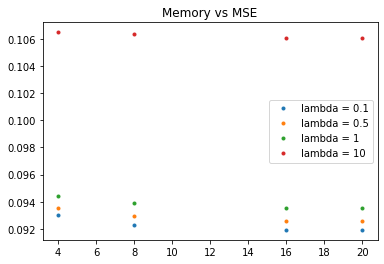

In [8]:
plt.title("Memory vs MSE") #### can update the code below with this type of loop
eAvg = np.sum(errorGpu,axis=2)/cvNum
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], eAvg[:,i], ".", label = f"lambda = {ridgeVec[i]}")
plt.legend()
plt.show()

In [9]:
#print(runTimesGpu)
#print("errors below")
#print(errorGpu)